# Prototpye 4 Intermediate - Using MEED dataset in a transformer

Use normalised keypoint values in a transformer.

Adding emotional encoding. This is how it is going to work. Encoded emotions is going to be added to each frame, so that model is more flexible during generation.

!The starting input is currently 1 long list of coords. But be careful because model might learn the transition between 1 video to another which is erroneous

Front videos only.



In [1]:
# set up environment
import glob
import os 
import numpy as np
import torch
import json
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Set root directory
root_dir = "C:\\Users\\avika\\OneDrive\\Documents\\UAL\\interactive_dance_thesis"
os.chdir(root_dir)

# Check if the current working directory was set correctly
print(os.getcwd())

C:\Users\avika\OneDrive\Documents\UAL\interactive_dance_thesis


## Load and preprocess data

In [2]:
import json
import logging
import glob

from typing import List

logger = logging.getLogger()
# Clear previous handlers
for handler in logger.handlers[:]:
    handler.close()
    logger.removeHandler(handler)

logging.basicConfig(filename= f"preprocessing_log.txt", level=logging.INFO, filemode='w')
# logging clear file
logger = logging.getLogger()

def interpolate(coord_prev, coord_next):
    """
    Linearly interpolate between two coordinates.
    
    Parameters:
    - coord_prev (float): Coordinate of the previous frame.
    - coord_next (float): Coordinate of the next frame.

    Returns:
    - (float): Interpolated coordinate.
    """
    return (coord_prev + coord_next) / 2

def preprocess_data(files: List[str]) -> dict:
    """
    Pre-process data by interpolating to avoid (0,0) keypoints.

    Parameters:
    - files (List[str]): List of file paths to process.

    Returns:
    - dict: Pre-processed data.
    """
    x_list=[]
    y_list=[]
    conf_list=[]
    emotions = []
    
    for file in tqdm(files):
        with open(file) as f:
            data = json.load(f)
            x = data['x']
            y = data['y']
            conf = data['confidence']
            emotions.extend(files[0].split('_')[-2].split('\\')[0][3:-3])
            
            for i in range(len(x)):
                # Check if coordinate is (0,0)
                if x[i] == 0 and y[i] == 0:
                    # logger.info(f"Found (0,0) at index {i} in file {file}")
                    # If first frame, copy from next frame
                    if i == 0:
                        j = i + 1
                        # Find next non-(0,0) frame
                        while x[j] == 0 and y[j] == 0:
                            j += 1
                        x[i] = x[j]
                        y[i] = y[j]
                    # If last frame, copy from previous frame
                    elif i == len(x) - 1:
                        x[i] = x[i-1]
                        y[i] = y[i-1]
                    # For a frame in the middle
                    else:
                        # Find the next non-(0,0) frame
                        j = i + 1
                        while j < len(x) and x[j] == 0 and y[j] == 0:
                            j += 1
                        # If no non-(0,0) frame found, use the previous frame, otherwise interpolate
                        if j == len(x):
                            x[i] = x[i-1]
                            y[i] = y[i-1]
                        else:
                            x[i] = interpolate(x[i-1], x[j])
                            y[i] = interpolate(y[i-1], y[j])
            
            x_list.append(x)
            y_list.append(y)
            conf_list.append(conf)

    return {"x": x_list, "y": y_list, "confidence": conf_list, "emotions": emotions}


files = glob.glob("G:/UAL_Thesis/affective_computing_datasets/multiview-emotional-expressions-dataset/*/front_*/processed_data.json")
processed_data = preprocess_data(files)
x_list = processed_data['x']
y_list = processed_data['y']
conf_list = processed_data['confidence']
emotions_labels = processed_data['emotions']

print(len(x_list))
print(len(emotions_labels))
# shape [num_frames, keypoints]

100%|██████████| 1326/1326 [00:08<00:00, 160.04it/s]

1326
1326


In [3]:
# ('A',Anger,'D',Disgust,'F',Fear,'H',Happiness,'N',Neutral,'SA',Sad,'SU',Surprise);

In [4]:
# check if there are still 0,0 coordinates

for i in range(len(x_list)):
    for j in range(len(x_list[i])):
        if x_list[i][j] == 0 and y_list[i][j] == 0:
            print(i,j)


In [5]:
def normalize_values_2D(frames):
    """
    Takes in a list of lists (frames), returns max and min values and normalized list
    
    Parameters:
        frames: List of lists containing keypoints for each frame.
    
    Returns:
        max_val: Maximum keypoint value across all frames.
        min_val: Minimum keypoint value across all frames.
        normalized_frames: Normalized keypoints for each frame.
    """
    # Flatten the data to find global min and max
    flat_data = [kp for frame in frames for kp in frame]
    max_val = max(flat_data)
    min_val = min(flat_data)
    
    # Normalize data
    normalized_frames = [
        [2 * (kp - min_val) / (max_val - min_val) - 1 for kp in frame]
        for frame in frames
    ]
    
    return max_val, min_val, normalized_frames

max_x, min_x, normalised_x = normalize_values_2D(x_list)
max_y, min_y, normalised_y = normalize_values_2D(y_list)
len(normalised_x)

1326

In [6]:
import cv2





#     # create 1D array of 50 numbers (x,y,x,y --> 25 keypoints) for each frame
# all_frames = []
# n_parts = 25

# for i in tqdm(range(0, len(x_list), n_parts)):
#     frame_data = [coord for pair in zip(x_list[i:i+n_parts], y_list[i:i+n_parts]) for coord in pair]
#     all_frames.append(frame_data)

# data has 0s - need to ignore

def visualise_skeleton(all_frames, max_x, max_y, max_frames=500, save=False, save_path=None, prefix=None):
    
    """Input all frames dim 50xn n being the number of frames 50= 25 keypoints x and y coordinates"""

    
    # visualise to check if the data is correct
    # BODY_25 Keypoints
    keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                        'L-Elb', 'L-Wr', 'MidHip', 'R-Hip', 'R-Knee', 'R-Ank', 
                        'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 
                        'L-Ear', 'L-BigToe', 'L-SmallToe', 'L-Heel', 'R-BigToe', 
                        'R-SmallToe', 'R-Heel']


    limb_connections = [
        ("Nose", "Neck"),
        ("Neck", "R-Sho"),
        ("R-Sho", "R-Elb"),
        ("R-Elb", "R-Wr"),
        ("Neck", "L-Sho"),
        ("L-Sho", "L-Elb"),
        ("L-Elb", "L-Wr"),
        ("Neck", "MidHip"),
        ("MidHip", "R-Hip"),
        ("R-Hip", "R-Knee"),
        ("R-Knee", "R-Ank"),
        ("MidHip", "L-Hip"),
        ("L-Hip", "L-Knee"),
        ("L-Knee", "L-Ank"),
        ("Nose", "R-Eye"),
        ("R-Eye", "R-Ear"),
        ("Nose", "L-Eye"),
        ("L-Eye", "L-Ear"),
        ("L-Ank", "L-BigToe"),
        ("L-Ank", "L-SmallToe"),
        ("L-Ank", "L-Heel"),
        ("R-Ank", "R-BigToe"),
        ("R-Ank", "R-SmallToe"),
        ("R-Ank", "R-Heel")
    ]
    
     # Define a mapping from emotion vectors to emotion labels
    # Define emotion labels
    emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']
    
    # Initialize a blank canvas (image)
    canvas_size = (int(max_y)+50, int(max_x)+50, 3)  
    canvas = np.zeros(canvas_size, dtype=np.uint8)

    # Define the codec and create VideoWriter object
    if save:
        # Determine the save path
        if save_path is None:
            save_path = "D:\\Interactive Dance Thesis Tests\\TransformerResults"

        # Ensure directory exists
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Determine a unique filename
        existing_files = os.listdir(save_path)
        file_num = 1
        while f"{prefix or ''}{file_num}.mp4" in existing_files:
            file_num += 1
        out_path = os.path.join(save_path, f"{prefix or ''}{file_num}.mp4")

        # Create the video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(out_path, fourcc, 10.0, (canvas_size[1], canvas_size[0]))

    # Iterate over every frame
    for frame_data in all_frames[:max_frames]:
        canvas_copy = canvas.copy()

        # Extract x and y coordinates
        x_coords = frame_data[0:50:2] 
        y_coords = frame_data[1:50:2]
        emotion_vector = tuple(frame_data[-7:])
        

        # Get emotion percentages and labels
        emotion_percentages = [f"{int(e * 100)}% {label}" for e, label in zip(emotion_vector, emotion_labels) if e > 0]


        # Plot keypoints on the canvas
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            x_val = x.item() if torch.is_tensor(x) else x
            y_val = y.item() if torch.is_tensor(y) else y
            cv2.circle(canvas_copy, (int(x_val), int(y_val)), 3, (0, 0, 255), -1)  
            cv2.putText(canvas_copy, keypointsMapping[i], (int(x_val), int(y_val)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        # Draw connections (limbs) on the canvas
        for limb in limb_connections:
            start_point = (int(x_coords[keypointsMapping.index(limb[0])]), int(y_coords[keypointsMapping.index(limb[0])]))
            end_point = (int(x_coords[keypointsMapping.index(limb[1])]), int(y_coords[keypointsMapping.index(limb[1])]))

            if start_point == (0,0) or end_point == (0,0):
                continue
            cv2.line(canvas_copy, start_point, end_point, (0, 255, 0), 2)  
        
        # Display the emotion percentages and labels on the top right of the frame
        y0, dy = 30, 15  # Starting y position and line gap
        for i, line in enumerate(emotion_percentages):
            y = y0 + i * dy
            cv2.putText(canvas_copy, line, (canvas_size[1] - 120, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)


        # Display the canvas with keypoints and connections
        cv2.imshow("Keypoints Visualization", canvas_copy)

        # If saving, write the frame to the video
        if save:
            out.write(canvas_copy)

        # Wait for 100ms and check for "esc" key press to exit
        key = cv2.waitKey(100)
        if key == 27:  
            break

    # Release the video writer, if used
    if save:
        out.release()

    cv2.destroyAllWindows()


In [7]:

# create 1D array of 50 numbers (x,y,x,y --> 25 keypoints) for each frame
kp_frames = []
n_parts = 25

for i in tqdm(range(0, len(normalised_x))):
    video_x = normalised_x[i]
    video_y = normalised_y[i]
    kp_frame= []
    for j in range(0,len(video_x), n_parts):
        frame_data = [coord for pair in zip(video_x[j:j+n_parts], video_y[j:j+n_parts]) for coord in pair]
        kp_frame.append(frame_data)
    kp_frames.append(kp_frame)

len(kp_frames[0][0])

100%|██████████| 1326/1326 [00:00<00:00, 2044.74it/s]


50

In [8]:
def emotion_labels_to_vectors(emotion_labels):
    """
    Convert a list of emotion labels to a list of continuous emotion vectors.

    Parameters:
    - emotion_labels (list of str): A list of emotion labels.
    
    Returns:
    - list of np.array: A list of continuous emotion vectors.
    """
    # Define a mapping from emotion labels to emotion vectors
    label_to_vector = {
        'A': [1, 0, 0, 0, 0, 0, 0],   # Anger
        'D': [0, 1, 0, 0, 0, 0, 0],   # Disgust
        'F': [0, 0, 1, 0, 0, 0, 0],   # Fear
        'H': [0, 0, 0, 1, 0, 0, 0],   # Happiness
        'N': [0, 0, 0, 0, 1, 0, 0],   # Neutral
        'SA': [0, 0, 0, 0, 0, 1, 0],  # Sad
        'SU': [0, 0, 0, 0, 0, 0, 1]   # Surprise
    }
    
    # Convert the labels to vectors using the mapping
    emotion_vectors = [label_to_vector[label] for label in emotion_labels]
    
    return emotion_vectors

# Convert labels to vectors
emotion_vectors = emotion_labels_to_vectors(emotions_labels)
emotion_vectors

[[1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0,

In [9]:
len(kp_frames[0][0])

50

In [10]:
kp_frames_with_emotion = []
# kp_frames is normalised

for i in tqdm(range(len(emotion_vectors))):
    # Use list concatenation instead of extend() to avoid in-place modification and None
    for frame in kp_frames[i]:
        frame.extend(emotion_vectors[i])
    kp_frames_with_emotion.append(kp_frames[i])
    

len(kp_frames_with_emotion[0][0])


100%|██████████| 1326/1326 [00:00<00:00, 29566.09it/s]


57

In [11]:
# Let's now split up the data into train and validation sets !FIX ALL VALIDATION BATCHES ARE ANGRY
n = int(0.9*len(kp_frames_with_emotion)) # first 90% will be train, rest val
train_data = kp_frames_with_emotion[:n]
val_data = kp_frames_with_emotion[n:]

In [12]:
import torch
torch.manual_seed(1337)
def get_batch(split, block_size, batch_size, device=device):
    data = train_data if split == 'train' else val_data
    
    # Choose random videos
    ix = torch.randint(len(data), (batch_size,))

    # For each chosen video, select a random starting point
    start_frames = [torch.randint(len(data[i]) - block_size, (1,)).item() for i in ix]

    # Extract subsequences from each chosen video and convert to tensors
    x = torch.stack([torch.tensor(data[i][start:start+block_size], dtype=torch.float32) for i, start in zip(ix, start_frames)])
    y = torch.stack([torch.tensor(data[i][start+1:start+block_size+1], dtype=torch.float32) for i, start in zip(ix, start_frames)])

    # Compute the mask to mask out -inf values
    mask = (x != float('-inf')).all(dim=-1).float()  # assuming -inf is present in any part of the data point

    # Move tensors to the designated device
    x, y, mask = x.to(device), y.to(device), mask.to(device)
    
    return x, y, mask
block_size = 10  # example block size
batch_size = 8   # example batch size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # example device

# Get a batch from training data (assuming data is a nested list)
xb, yb, mask = get_batch('train',  block_size, batch_size, device)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')



inputs:
torch.Size([8, 10, 57])
tensor([[[ 2.1034e-01, -4.6205e-01,  1.6415e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.1540e-01, -4.6203e-01,  1.6916e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.2557e-01, -4.6211e-01,  1.6426e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 2.5114e-01, -4.5628e-01,  1.6420e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.5130e-01, -4.5617e-01,  1.6415e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.4114e-01, -4.5016e-01,  1.6908e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 7.6886e-02, -3.8021e-01,  9.7409e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 8.7196e-02, -3.9179e-01,  1.0269e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 9.7363e-02, -3.9196e-01,  1.0787e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
       

In [13]:
emotions_list = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']



In [14]:
import torch

def validate_emotion_consistency(x, y):
    """
    Validate that the emotion code (last 7 elements of each frame) is consistent
    between corresponding frames in x and y.

    Parameters:
    - x (Tensor): Input sequences (batch_size, sequence_length, frame_length)
    - y (Tensor): Target sequences (batch_size, sequence_length, frame_length)
    
    Returns:
    - bool: True if emotions are consistent, False otherwise
    """
    # Extract the emotion encodings from x and y
    emotion_x = x[:, :, -7:]
    emotion_y = y[:, :, -7:]

    # Check if the emotion encodings are equal in x and y
    emotion_equal = torch.all(emotion_x == emotion_y, dim=-1)
    
    # Check equality across sequence length (assuming dim 1 is sequence_length)
    emotion_equal = torch.all(emotion_equal, dim=-1)

    # Check if all batches have consistent emotions
    all_equal = torch.all(emotion_equal)

    return all_equal.item()


# Example tensors (ensure your actual tensors match these dimensions)


# Validate emotion consistency
is_consistent = validate_emotion_consistency(xb, yb)

# Output result
if is_consistent:
    print("Emotions are consistent between x and y.")
else:
    print("Emotions are NOT consistent between x and y.")


Emotions are consistent between x and y.


In [15]:
yb.shape

torch.Size([8, 10, 57])

In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

torch.manual_seed(1337)

# let's start with a very simple model

def positional_encoding(seq_len, d_model):
    """
    Returns the positional encoding for a given sequence length and model size.

    Parameters:
    - seq_len (int): Length of the sequence.
    - d_model (int): Size of the model embedding.

    Returns:
    - A tensor of shape (seq_len, d_model) containing the positional encoding.
    """
    
    position = torch.arange(seq_len).unsqueeze(1).float() # [seq_len, 1]
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                         (-math.log(10000.0) / d_model))  # [d_model/2]
    pos_enc = torch.zeros((seq_len, d_model))

    pos_enc[:, 0::2] = torch.sin(position * div_term) # apply sin to even indices in the array; 2i
    pos_enc[:, 1::2] = torch.cos(position * div_term) # apply cos to odd indices in the array; 2i+1

    return pos_enc


class Head(nn.Module):
    """one head of self attention"""
    
    def __init__(self,head_size,n_emb,dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.query = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.value = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.n_emb = n_emb
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        B,T,C = x.shape # batch size, time, context
        # key, query, value
        k = self.key(x) # B,T,C
        q = self.query(x) # B,T,C
        v= self.value(x) # B,T,C
        
        # compute attention scores ("affinities")
         # Scaled dot-product attention - same as below
        # attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) / math.sqrt(self.embed_size)

        wei = q @ k.transpose(-1,-2) # B,T,T
        wei /= math.sqrt(self.n_emb) # scale by sqrt of embedding dimension
        self.tril = self.tril.to(device)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # mask out upper triangular part so don't attend to future
        wei = F.softmax(wei, dim=-1) # B,T,T
        wei = self.dropout(wei)
        # apply attention to values - weighted aggregation
        out = wei @ v # (B,T,T) @ (B,T,C) --> B,T,C
        
        return out
        
        
class MultiHeadAttention(nn.Module):
    
    def __init__(self,num_heads,head_size,n_emb,dropout=0.2):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size,n_emb) for _ in range(num_heads)])
        self.proj = nn.Linear(n_emb, n_emb, bias=False, device=device) # (B,T,C) - projection back into residual pathway
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x is (B,T,C)
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B,T,C*num_heads)
        out = self.dropout(self.proj(out)) # (B,T,C) - projection back into residual pathway
        
        return out
    
class FeedForward(nn.Module):
    """A simple lineear layer followed by a ReLU - allows all tokens to think on data individually"""
    
    def __init__(self,n_emb,dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_emb, 4 * n_emb , device=device), # 4 * because recommended in paper residual pathway - growing residual pathway
            nn.ReLU(),
            nn.Linear( 4* n_emb, n_emb , device=device), # required otherwise output will collapse  - projection back into residual pathway
            nn.Dropout(dropout)
          
        )
    
    def forward(self, x):
        return self.net(x)
    

class Block(nn.Module):
    """Transformer Block: communication followed by computation - basically self attention heads and feedforward"""

    def __init__(self, n_emb, n_heads):
        
        super().__init__()
        head_size = n_emb//n_heads
        self.sa = MultiHeadAttention(num_heads=n_heads, head_size=head_size, n_emb=n_emb)
        self.ffwd = FeedForward(n_emb=n_emb)
        self.ln1 =  nn.InstanceNorm1d(n_emb , device=device)
        self.ln2 =  nn.InstanceNorm1d(n_emb, device=device)
        
    def forward(self, x):
        # x + due to residual connection
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class MotionModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim=256, n_layers=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False, device=device)  #input to hidden dim
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=False,device=device)  #reshape hidden to output dim
        self.positional_encoding = positional_encoding(seq_len=block_size, d_model=hidden_dim).to(device)
        layers = [Block(n_emb=hidden_dim, n_heads=4) for _ in range(n_layers)]
        layers.append(nn.InstanceNorm1d(hidden_dim, device=device))
        self.blocks = nn.Sequential(*layers)

        self.lm_head = nn.Linear(hidden_dim, hidden_dim, bias=False, device=device)
       
    
        
    def forward(self, inputs, targets=None ,mask=None):
        B,T,C = inputs.shape # batch size, time, context
        
        # fc1 transforms input into hidden dimension
        x = self.fc1(inputs) # B,T,hidden dimension
        # Add positional encoding
       
        x += positional_encoding(seq_len=T, d_model=self.hidden_dim).to(device) # positional_encoding = T,hidden dimension , added = B,T,hidden dimension
        
        x = self.blocks(x) # B,T,hidden dimension
        x = self.lm_head(x) # B,T,hidden dimension
        
        # fc2 transforms hidden dimension into output dimension
        logits = self.fc2(x)
        
        
        if targets is None:
            loss = None
        
        else:
            B,T,C = inputs.shape # batch size, time, context
            loss = F.mse_loss(logits, targets) # mse picked cause continous data
            # adding mask to ignore 0,0 occlusions (-inf)
            # if mask is None:
            #     mask = (inputs != float('-inf')).all(dim=-1).float() 
              
            # loss = F.mse_loss(logits * mask.unsqueeze(-1), targets * mask.unsqueeze(-1), reduction='sum') / mask.sum()

        
        return logits,loss
    
    def generate(self,inputs,max_new_tokens):
        # inputs is (B,T) array of indices in current context
        # get current prediction
    
        generated_sequence = inputs
        
        for _ in range(max_new_tokens):
            cond_sequence = generated_sequence[:, -block_size:] # get the last block_size tokens from the generated sequence so positional doesn't run out
            # don't actually need to do this cause positional is sinusoidal but just in case since model trained with blocksize
            logits, _ = self(cond_sequence)
            next_values = logits[:, -1, :]  # Get the values from the last timestep
            
            # Append the predicted values to the sequence
            generated_sequence = torch.cat([generated_sequence, next_values.unsqueeze(1)], dim=1)
        
        return generated_sequence

# output dim should be the same size as target dim
m = MotionModel(input_dim=57, output_dim=57)
out,loss = m(xb, yb)
print(out.shape)
print(out)
# loss interpreted on scale of data
print(f"loss: {loss}")


            
    

torch.Size([8, 10, 57])
tensor([[[-2.4652e-01,  2.5268e-01,  4.8962e-01,  ...,  4.6004e-02,
           3.5762e-01, -5.1999e-01],
         [ 1.4183e-01, -8.0512e-02,  5.2776e-01,  ...,  1.7338e-01,
           3.6658e-01,  4.8682e-02],
         [ 3.2835e-04,  1.0642e-01,  3.8007e-01,  ...,  1.2639e-01,
           3.2196e-01, -9.8446e-02],
         ...,
         [-3.7989e-01,  5.3269e-01,  3.4559e-01,  ...,  1.8851e-01,
           2.2508e-02, -2.9736e-01],
         [-2.3859e-01,  3.2742e-01,  9.6280e-02,  ...,  3.3373e-01,
          -2.7553e-01, -1.6872e-01],
         [-4.7830e-01,  6.0562e-01,  1.3307e-01,  ...,  9.5172e-02,
           4.0212e-02, -1.2336e-01]],

        [[ 8.1328e-02,  1.1428e-01,  4.6703e-01,  ...,  6.9837e-02,
           1.3358e-01, -6.5106e-02],
         [ 1.2646e-01,  2.8588e-01,  3.6268e-01,  ...,  1.0876e-01,
           4.2022e-02, -6.5093e-01],
         [-3.1011e-01,  4.5299e-01,  5.2181e-01,  ...,  2.9340e-01,
           2.6440e-01, -1.8094e-01],
         ...,
 

In [17]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.0001)

  0%|          | 5/50000 [01:48<224:08:05, 16.14s/it]  

train loss: 0.001589 val loss: 0.001799


 10%|█         | 5005/50000 [06:21<85:53:15,  6.87s/it] 

train loss: 0.000650 val loss: 0.000665


 20%|██        | 10005/50000 [10:58<71:07:34,  6.40s/it] 

train loss: 0.000583 val loss: 0.000613


 30%|███       | 15005/50000 [15:30<67:47:45,  6.97s/it] 

train loss: 0.000548 val loss: 0.000548


 40%|████      | 20005/50000 [19:58<48:50:20,  5.86s/it]

train loss: 0.000523 val loss: 0.000559


 50%|█████     | 25004/50000 [24:24<49:22:39,  7.11s/it]

train loss: 0.000531 val loss: 0.000587


 60%|██████    | 30004/50000 [28:57<34:43:52,  6.25s/it]

train loss: 0.000442 val loss: 0.000500


 70%|███████   | 35005/50000 [33:22<23:01:57,  5.53s/it]

train loss: 0.000454 val loss: 0.000494


 80%|████████  | 40004/50000 [37:53<19:43:58,  7.11s/it]

train loss: 0.000432 val loss: 0.000499


 90%|█████████ | 45005/50000 [42:33<10:12:34,  7.36s/it]

train loss: 0.000407 val loss: 0.000489


100%|██████████| 50000/50000 [45:13<00:00, 18.42it/s]   


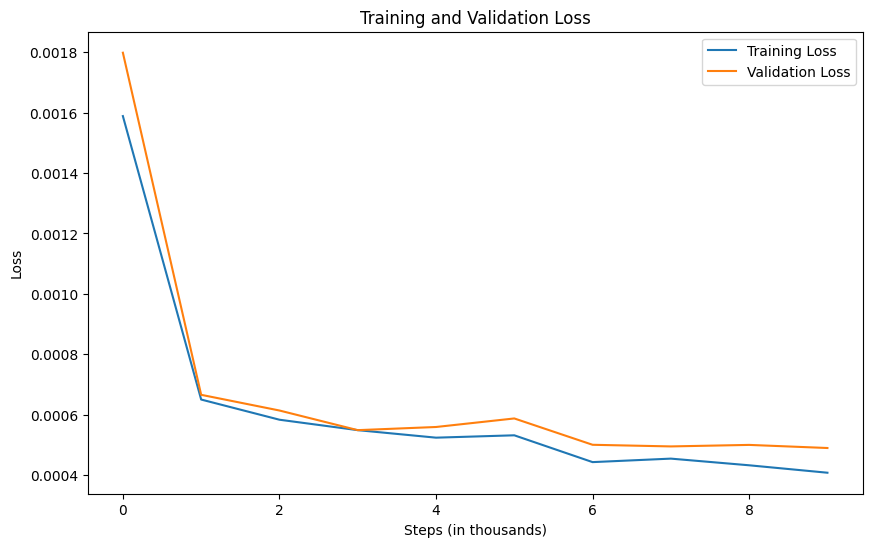

In [24]:
# training loop

import matplotlib.pyplot as plt

@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    eval_iters = 5000
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb, mask = get_batch(split,  block_size, batch_size, device)
            logits, loss = m(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out


batch_size = 8
train_losses = []
val_losses = []
for steps in tqdm(range(50000)):
    # get sample batch of data
    xb,yb,mask = get_batch('train',  block_size, batch_size, device)
    # evaluate loss
    logits, loss = m(xb,yb, mask)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if steps % 5000 == 0:
        losses = estimate_loss()
        print(f"train loss: {losses['train']:.6f} val loss: {losses['val']:.6f}")
        
         # Store the losses for plotting
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Steps (in thousands)')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# After the training loop, plot the losses
plot_losses(train_losses, val_losses)

In [25]:
import os

checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "proto4_checkpoint.pth")

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Try to delete the file (be cautious with this step)
try:
    os.remove(checkpoint_path)
except FileNotFoundError:
    print(f"{checkpoint_path} not found, proceeding...")
except PermissionError:
    print(f"Cannot delete {checkpoint_path}. Check permissions.")

# Test write permissions
try:
    with open(checkpoint_path, 'w') as f:
        f.write("test")
except PermissionError:
    print(f"Cannot write to {checkpoint_path}. Check permissions.")


In [28]:
# generate new sequence
xb,yb,mask = get_batch('test', block_size, batch_size, device)

generated = m.generate(xb, 300)
print(generated.shape)

torch.Size([8, 310, 57])


In [29]:
def unnormalise_list(data_tensor, max_x, min_x, max_y, min_y):
    all_frames = []
    # Loop through each batch
    for batch_idx in range(data_tensor.size(0)):
        batch_frames = []
        # Loop through each frame in the batch
        for frame_idx in range(data_tensor.size(1)):
            frame_data = data_tensor[batch_idx, frame_idx, :]
            unnormalized_data = []
            # Loop through the coordinate pairs and unnormalize
            for i in range(0, 50, 2):  
                x = frame_data[i]
                y = frame_data[i+1]
                unnormalized_x = (x+1)/2 * (max_x-min_x) + min_x
                unnormalized_y = (y+1)/2 * (max_y-min_y) + min_y
                unnormalized_data.extend([unnormalized_x.item(), unnormalized_y.item()])
            # Append the emotion encoding without unnormalizing
            unnormalized_data.extend(frame_data[-7:].tolist())
            batch_frames.append(unnormalized_data)
        all_frames.append(batch_frames)
    return all_frames



unnorm_out = unnormalise_list(generated, max_x, min_x, max_y, min_y)

# visualise and save
for batch in unnorm_out:
    visualise_skeleton(batch, max_x, max_y, max_frames=300,save = True,save_path=None,prefix='adam_10000steps_proto4')

KeyboardInterrupt: 

In [ ]:
# # continuous GPT


# import torch
# import torch.nn as nn
# from torch.nn import functional as F
# import math

# torch.manual_seed(1337)


# # this is set to eval mode because we don't want to train the model, we just want to estimate the loss, for this model the modes won't be different
# # but for other models, the modes will be different depending on what layers are present
# # torch.no_grad() - we don't want to calculate gradients because we don't want to train the model, we will not call backward, better memory management
# @torch.no_grad()
# def estimate_loss():
#     out = {}
#     model.eval()
#     eval_iters = 200
#     for split in ['train', 'val']:
#         losses = torch.zeros(eval_iters)
#         for k in range(eval_iters):
#             xb, yb = get_batch(split)
#             logits, loss = model(xb, yb)
#             losses[k] = loss.item()
#         out[split] = losses.mean()
#     model.train()
#     return out

# def positional_encoding(seq_len, d_model):
#     """
#     Returns the positional encoding for a given sequence length and model size.

#     Parameters:
#     - seq_len (int): Length of the sequence.
#     - d_model (int): Size of the model embedding.

#     Returns:
#     - A tensor of shape (seq_len, d_model) containing the positional encoding.
#     """
    
#     position = torch.arange(seq_len).unsqueeze(1).float() # [seq_len, 1]
#     div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
#                          (-math.log(10000.0) / d_model))  # [d_model/2]
#     pos_enc = torch.zeros((seq_len, d_model))

#     pos_enc[:, 0::2] = torch.sin(position * div_term) # apply sin to even indices in the array; 2i
#     pos_enc[:, 1::2] = torch.cos(position * div_term) # apply cos to odd indices in the array; 2i+1

#     return pos_enc



# class MotionModel(nn.Module):

#     def __init__(self, input_dim, hidden_dim, num_heads, num_layers):
#         super().__init__()

#         # Initial transformation layer
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
        
#         # Transformer layers
#         encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Positional encoding
#         self.positional_encoding = positional_encoding(seq_len=block_size, d_model=hidden_dim).to(device)

#         # Output layer
#         self.fc2 = nn.Linear(hidden_dim, input_dim)

#     def forward(self, pose_sequence,targets=None):
#         # Feature transformation
#         x = self.fc1(pose_sequence)

#         # Add positional encoding
#         seq_len = x.shape[1]
#         x += self.positional_encoding[:seq_len, :]


#         # Transformer layers
#         x = self.transformer(x)

#         # Predicting the next pose
#         logits = self.fc2(x)
        
        
#         if targets is None:
#             loss = None
#         else:
#             B, T, C = logits.shape
#             # pytorch wants (B*T,C) so we have to transpose because it wants C in the 2nd dimension
#             logits = logits.view(B*T, C)
#             # look at prediction
#             targets = targets.view(B*T, -1)

#             # evaluate loss
#             # negative log likelihood loss a.k. cross entropy loss
#             # we have the identity of the next character so how well are we predicting the next character based on the logits
#             # ideally the correct logits should be 1 and the rest should be 0, but in reality this is not the case
            
#             loss = F.cross_entropy(logits, targets)

#         return logits,loss

#     def training_step(self, pose_sequence, next_pose):
#         predicted_pose = self(pose_sequence)
#         loss = nn.MSELoss()(predicted_pose, next_pose)
#         return loss
    
#     def generate(self, initial_pose_sequence, max_new_poses):
#         """
#         Generate a sequence of poses.

#         Parameters:
#         - initial_pose_sequence: Starting sequence of poses.
#         - max_new_poses: Maximum number of new poses to generate.

#         Returns:
#         - Generated sequence of poses.
#         """

#         generated_sequence = initial_pose_sequence

#         for _ in range(max_new_poses):
#             # Get the predicted next pose
#             logits, _ = self(generated_sequence)
#             next_pose = logits


#             # Append the predicted pose to the sequence
#             generated_sequence = torch.cat([initial_pose_sequence,next_pose],dim=1)  # Add sequence dimension


#         return generated_sequence



# model = MotionModel(input_dim=50, hidden_dim=128, num_heads=4, num_layers=4)
# m = model.to(device)
# logits, loss = m(xb, yb)
# print(logits.shape)
# print(loss)
# output= m.generate(initial_pose_sequence=xb[0], max_new_poses=100)[0].tolist()
# print(np.shape(output))



In [ ]:
# # Preprocess the MEED dataset for transformer
# # 1D array of 50 (25 keypoints x,y ) = 1 frame = 1 token
# # block size of 10 so input is 10x50 dims

# from torch.utils.data import DataLoader, TensorDataset, random_split

# # Example: load your keypoints from a file, preprocess, and convert them into PyTorch tensors
# # keypoints = ...
# # For the sake of this example, let's assume keypoints is a torch.Tensor of shape [num_samples, sequence_len, 50]

# # Create data loaders
# batch_size = 32
# train_loader = DataLoader(xb, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(yb, batch_size=batch_size, shuffle=False)


In [ ]:
# transformer


In [ ]:
# visualise results